Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


Linear(in_features=2048, out_features=1000, bias=True)
Linear(in_features=2048, out_features=196, bias=True)
Using 'cuda:0' to train the Model !
Epoch 1, duration: 127 s, loss: 5.2670, acc: 0.1274
Accuracy of the network on the test images: 2 %
Epoch 2, duration: 118 s, loss: 5.0021, acc: 0.3481
Accuracy of the network on the test images: 9 %
Epoch 3, duration: 117 s, loss: 4.4257, acc: 0.9572
Accuracy of the network on the test images: 19 %
Epoch 4, duration: 118 s, loss: 3.8274, acc: 1.9020
Accuracy of the network on the test images: 36 %
Epoch 5, duration: 118 s, loss: 3.3457, acc: 2.8748
Accuracy of the network on the test images: 46 %
Epoch 6, duration: 117 s, loss: 2.9623, acc: 3.8010
Accuracy of the network on the test images: 54 %
Epoch 7, duration: 117 s, loss: 2.7094, acc: 4.3821
Accuracy of the network on the test images: 59 %
Epoch 8, duration: 117 s, loss: 2.4607, acc: 5.0535
Accuracy of the network on the test images: 62 %
Epoch 9, duration: 116 s, loss: 2.2779, acc: 5.49

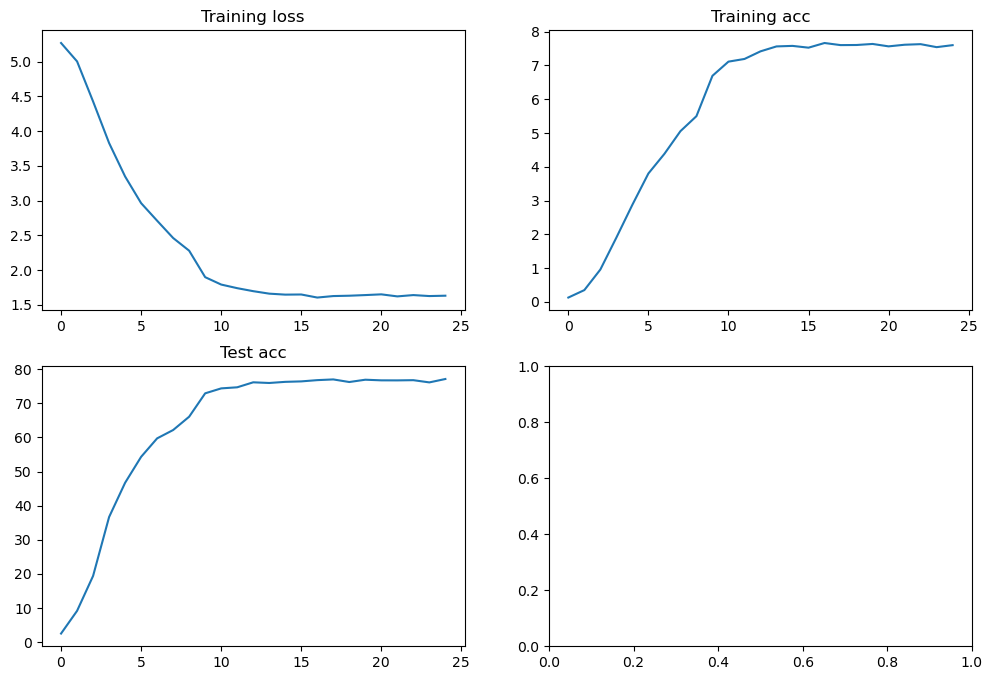

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms

import time

def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []
    # SET THE MODEL TO TRAIN MODE INITIALLY
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_loader, 0):

            # GET THE INPUTS AND ASSIGN THEM TO CUDA
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # FORWARD + BACKWARD + OPTIMIZE
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # CALCULATE THE LOSS/ACC LATER
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # SWITCH THE MODEL TO EVAL MODE TO EVALUATE ON TEST DATA
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # RE-SET THE MODEL TO TRAIN MODE AFTER VALIDATING
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (test_acc))
    return test_acc

if __name__ == '__main__':

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(35),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.RandomGrayscale(p=0.5),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.RandomPosterize(bits=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])

    train_dataset = datasets.ImageFolder(
        root='/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test',
        transform=train_transforms
    )
    val_dataset = datasets.ImageFolder(
        root='/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train',
        transform=val_transforms
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=2
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=2
    )

    model = models.resnet50(weights="IMAGENET1K_V2")
    print(model.fc)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 196)

    print(model.fc)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using '{device}' to train the Model !")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

    # TRAINING THE MODEL
    
    model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, lrscheduler, n_epochs=25)
    
    # SAVING THE TRAINED MODEL IN LOCAL
    
    torch.save(model.state_dict(), "./trainedModelFinal.pt")
    
    # SHOWCASING THE TRAINING PROGRESS
    
    f, axarr = plt.subplots(2,2, figsize = (12, 8))
    axarr[0, 0].plot(training_losses)
    axarr[0, 0].set_title("Training loss")
    axarr[0, 1].plot(training_accs)
    axarr[0, 1].set_title("Training acc")
    axarr[1, 0].plot(test_accs)

    axarr[1, 0].set_title("Test acc")
    
    model.eval()